# Modeling Notebook 2

This notebook will contain continued model iterations.  After more consideration, my group has decided to focus only on the city of Chicago, rather than Chicago metro area. This will shrink the zip codes we are looking at considerably (from 325 to 41). This will also allow us to create a map of the Chicago zip codes. From these 41 zip codes, we are going to calculate 5yrROI and determine the top 21 to look at from that list.

## Plan 
- Subset dataframe
- Focus on one zip code to create improved model
- Apply to other zip codes
- Determine top 5 based on model forecasts.

In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error as mse

%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf
import src.cleaning_functions as cf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Subset Dataframe

In [4]:
df = pd.read_csv('../../data/zillow_data.csv')

In [30]:
chicago = df[df['Metro'] == 'Chicago']

In [58]:
chicago['5yrROI'] = ((chicago['2018-04'] - chicago['2013-04'])/chicago['2013-04']) * 100
chicago['2yrROI'] = ((chicago['2018-04'] - chicago['2016-04'])/chicago['2016-04']) * 100

In [59]:
roi5 = chicago.sort_values('5yrROI', ascending=False)[:15]

In [60]:
roi2 = chicago.sort_values('2yrROI', ascending=False)[:15]

In [61]:
roi5_regions = roi5['RegionName'].values
roi2_regions = roi2['RegionName'].values

In [62]:
roi5_regions

array([60804, 60085, 60153, 60110, 60104, 60505, 60651, 60073, 60436,
       60639, 60120, 60165, 60160, 60641, 60042])

In [63]:
same = []
for region in roi5_regions:
    if region in roi2_regions:
        same.append(region)

In [64]:
same

[60085, 60505, 60436]

In [66]:
regions = []
for region in roi5_regions:
    regions.append(region)
for region in roi2_regions:
    if region not in regions:
        regions.append(region)
len(regions)

27

In [67]:
regions_df = df[df['RegionName'].isin(regions)]

In [68]:
regions_df.shape

(27, 272)

In [69]:
regions_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
332,84641,60641,Chicago,IL,Chicago,Cook,333,135700.0,136200.0,136400.0,136300.0,135800.0,135100.0,134000.0,132700.0,131500.0,130500.0,129200.0,127700.0,126300.0,125200.0,124300.0,123800.0,123600.0,123900.0,124700.0,125900.0,128000.0,130500.0,132900.0,135100.0,137500.0,139900.0,142100.0,144200.0,146100.0,147800.0,149200.0,150400.0,151600.0,...,231400,232500,234400,237000,239600,241900,243000,243300,244600,247900,251600,253600,254600,255200,255900,256600,256900,257000,257400,259000,261200,263400,265400,267300,268300,270100,272500,274500,276700,279200,281200,282300,283400,284900,286100,286900,288300,289800,291000,291500
383,84340,60085,Waukegan,IL,Chicago,Lake,384,96100.0,96700.0,97100.0,97300.0,97200.0,96900.0,96400.0,95700.0,95100.0,94600.0,93800.0,92700.0,91700.0,90800.0,90000.0,89300.0,88700.0,88400.0,88300.0,88400.0,88900.0,89800.0,90800.0,91800.0,93200.0,94700.0,96400.0,98200.0,100100.0,101900.0,103500.0,104800.0,106000.0,...,69500,69200,70300,72000,73400,73300,73600,73800,73300,72500,73100,73600,74200,75400,77200,78700,81400,84500,86400,87700,88800,89700,91900,95200,98000,100200,102500,104600,106000,106200,106500,107100,107300,106800,107200,107600,108600,110800,113400,114500
658,84639,60639,Chicago,IL,Chicago,Cook,659,111200.0,111900.0,112300.0,112500.0,112500.0,112100.0,111500.0,110700.0,109900.0,109200.0,108300.0,107000.0,105900.0,104800.0,103900.0,103300.0,102800.0,102800.0,103000.0,103600.0,104800.0,106500.0,108200.0,109800.0,111500.0,113300.0,115000.0,116600.0,118100.0,119400.0,120600.0,121500.0,122600.0,...,171300,173000,175400,178200,181300,183700,184400,184200,184200,184400,184600,185600,186400,186900,188000,189800,191300,193000,195500,198700,202200,205700,209900,213900,216500,217300,217500,218100,219700,221200,222400,223100,222900,223300,224600,226100,228700,231400,232700,232600
725,84329,60073,Round Lake Beach,IL,Chicago,Lake,726,125200.0,126100.0,126600.0,126700.0,126400.0,125700.0,124600.0,123200.0,121800.0,120500.0,118800.0,116800.0,114900.0,113200.0,111800.0,110600.0,109700.0,109200.0,109100.0,109400.0,110300.0,111700.0,113300.0,115000.0,117200.0,119600.0,122100.0,124400.0,126500.0,128300.0,129500.0,130300.0,130800.0,...,107000,108300,109600,111400,113400,115400,117400,119000,120200,121200,121800,122100,121800,121600,121900,123000,124300,125500,126600,127400,127500,128000,129500,131600,133200,134600,136000,137100,138100,138600,139000,139700,140400,141200,142300,143400,144600,146300,147700,148100
948,84693,60804,Cicero,IL,Chicago,Cook,949,96500.0,97000.0,97300.0,97300.0,97100.0,96600.0,95800.0,94700.0,93800.0,92900.0,91900.0,90500.0,89100.0,88000.0,87000.0,86100.0,85500.0,85100.0,85000.0,85200.0,85900.0,86900.0,87900.0,88800.0,89900.0,91100.0,92300.0,93600.0,94900.0,96200.0,97400.0,98400.0,99400.0,...,115400,115800,116200,118100,121300,124100,126300,128600,129800,130200,130700,132200,134300,136700,138400,139200,140300,141500,142500,142900,142700,142800,143900,145200,146500,147400,148200,149900,152000,153500,154800,155800,156800,157900,159200,160500,161800,162900,163800,164400
1392,84541,60505,Aurora,IL,Chicago,Kane,1393,79300.0,80000.0,80200.0,80100.0,79700.0,78800.0,77700.0,76400.0,75100.0,73900.0,72600.0,71200.0,70000.0,69000.0,68200.0,67700.0,67400.0,67300.0,67300.0,67400.0,67900.0,68600.0,69400.0,70000.0,71000.0,72200.0,73700.0,75400.0,77200.0,79100.0,80800.0,82300.0,83800

In [87]:
regions_melted = mcf.melt_data(regions_df)

In [94]:
regions_melted.set_index('time', inplace=True)

In [97]:
regions_melted

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,value
time,,,,,,,,
1996-04-01,60641,Chicago,IL,Chicago,Cook,84641,333,135700.0
1996-04-01,60085,Waukegan,IL,Chicago,Lake,84340,384,96100.0
1996-04-01,60639,Chicago,IL,Chicago,Cook,84639,659,111200.0
1996-04-01,60073,Round Lake Beach,IL,Chicago,Lake,84329,726,125200.0
1996-04-01,60804,Cicero,IL,Chicago,Cook,84693,949,96500.0
...,...,...,...,...,...,...,...,...
2018-04-01,60456,Hometown,IL,Chicago,Cook,84507,11218,122500.0
2018-04-01,60163,Berkeley,IL,Chicago,Cook,84412,11236,180100.0
2018-04-01,60165,Stone Park,IL,Chicago,Cook,84414,12717,156000.0


In [102]:
train_dfs = []
test_dfs = []
for region in regions:
    train, test = mcf.train_test_split(df, region, '2013-01-01', '2017-10-01')
    train_dfs.append(train)
    test_dfs.append(test)

In [114]:
regions[0]

60804

In [115]:
train_dfs[0]

time
2013-01-01     79100.0
2013-02-01     78400.0
2013-03-01     79600.0
2013-04-01     81100.0
2013-05-01     81400.0
2013-06-01     81700.0
2013-07-01     82900.0
2013-08-01     84400.0
2013-09-01     86000.0
2013-10-01     87200.0
2013-11-01     87900.0
2013-12-01     88800.0
2014-01-01     90300.0
2014-02-01     92300.0
2014-03-01     94300.0
2014-04-01     95200.0
2014-05-01     95700.0
2014-06-01     97000.0
2014-07-01     99000.0
2014-08-01    100700.0
2014-09-01    103000.0
2014-10-01    106900.0
2014-11-01    111300.0
2014-12-01    114000.0
2015-01-01    115400.0
2015-02-01    115800.0
2015-03-01    116200.0
2015-04-01    118100.0
2015-05-01    121300.0
2015-06-01    124100.0
2015-07-01    126300.0
2015-08-01    128600.0
2015-09-01    129800.0
2015-10-01    130200.0
2015-11-01    130700.0
2015-12-01    132200.0
2016-01-01    134300.0
2016-02-01    136700.0
2016-03-01    138400.0
2016-04-01    139200.0
2016-05-01    140300.0
2016-06-01    141500.0
2016-07-01    142500.0
2016-0

In [120]:
results = auto_arima(train_dfs[0], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=943.093, BIC=947.179, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=913.256, BIC=919.385, Fit time=0.051 seconds
Fit ARIMA: order=(0, 1, 1); AIC=897.324, BIC=903.453, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 1); AIC=886.954, BIC=895.126, Fit time=0.078 seconds
Fit ARIMA: order=(1, 1, 2); AIC=877.539, BIC=887.754, Fit time=0.117 seconds
Fit ARIMA: order=(2, 1, 3); AIC=879.942, BIC=894.243, Fit time=0.412 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=879.438, BIC=891.697, Fit time=0.173 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=0.087 seconds
Total fit time: 0.975 seconds


In [122]:
results.order

(1, 1, 2)

In [123]:
orders = []
for i in range(len(regions)):
    result = auto_arima(train_dfs[i], start_p=0, start_q=0, max_p=6, max_q=6, seasonal=False, trace=True)
    orders.append(result.order)

er=(4, 1, 3); AIC=935.153, BIC=953.540, Fit time=0.358 seconds
Fit ARIMA: order=(3, 1, 4); AIC=nan, BIC=nan, Fit time=0.170 seconds
Total fit time: 2.618 seconds
Fit ARIMA: order=(0, 1, 0); AIC=939.970, BIC=944.056, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=894.059, BIC=900.188, Fit time=0.046 seconds
Fit ARIMA: order=(0, 1, 1); AIC=890.695, BIC=896.825, Fit time=0.048 seconds
Fit ARIMA: order=(1, 1, 1); AIC=875.813, BIC=883.986, Fit time=0.081 seconds
Fit ARIMA: order=(1, 1, 2); AIC=867.344, BIC=877.559, Fit time=0.150 seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=869.343, BIC=881.602, Fit time=0.124 seconds
Fit ARIMA: order=(1, 1, 3); AIC=869.343, BIC=881.602, Fit time=0.182 seconds
Total fit time: 0.646 seconds
Fit ARIMA: order=(0, 1, 0); AIC=934.693, BIC=938.779, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=906.504, BIC=912.633, Fit 

In [157]:
results = {}
import itertools
p = q = d = range(0, 2)
pdq = list(itertools.product(p, d , q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
#for i in pdq:
#    for s in seasonal_pdq:
#        print('SARIMAX: {} x {}'.format(i, s))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_dfs[0],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            result = mod.fit()
            results[result.aic] = (param, param_seasonal)
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,result.aic))
        except: 
            print('hello')
            continue

Examples of parameter for SARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1499.2096584151604
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:86943.63024027977
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1014.4331334010394
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1078.809091469911
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:955.3502051597952
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:965.5166028475762
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:711.6741999147864
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1286.3382929352892
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1436.0605249965015
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:79594.74887246189
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:998.2651571245942
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1169.8757715312584
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1180.4237969837798
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:742.4134596669287
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:nan
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:992.0157970042696
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:775.6186107901267
ARIMA(0, 1, 0)x(0, 1, 0, 12) - A

In [159]:
np.min([x for x in results.keys() if str(x) != 'nan'])

524.3379243343746

In [160]:
results[524.3379243343746]

((1, 1, 0), (1, 1, 0, 12))

In [163]:
sarimax_orders = []
for i in range(len(regions)):
    results = {}
    import itertools
    p = q = d = range(0, 2)
    pdq = list(itertools.product(p, d , q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter for SARIMA...')
    #for i in pdq:
    #    for s in seasonal_pdq:
    #        print('SARIMAX: {} x {}'.format(i, s))
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod =SARIMAX(train_dfs[i],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                result = mod.fit()
                results[result.aic] = (param, param_seasonal)
                print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,result.aic))
            except: 
                print('hello')
                continue
    min_ = np.min([x for x in results.keys() if str(x) != 'nan'])
    sarimax_orders.append(results[min_])

1, 12) - AIC:1047.9849965345563
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:762.4016548645958
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:742.8291983313272
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:575.7279668851925
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:998.1572303532539
Examples of parameter for SARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1461.7388990267168
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:77403.05882132132
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:937.6020534217223
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1214.4276946993186
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:939.9684598015126
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:955.8478471321504
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:706.8856331617856
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1081.02151487344
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1398.6156090760403
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:68131.19044589797
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:923.5431518588565
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1138.550017510891
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1091.195

In [164]:
sarimax_orders

[((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12))]

In [165]:
regions[5]

60505

In [166]:
sarimax_60505 = SARIMAX(train_dfs[5], order=sarimax_orders[5][0], seasonal_order=sarimax_orders[5][1], enforce_stationarity=False, enforce_invertibility=False).fit()

In [168]:
test_60505_preds = sarimax_60505.predict(start=test_dfs[5].index[0], end=test_dfs[5].index[-1], typ='levels')

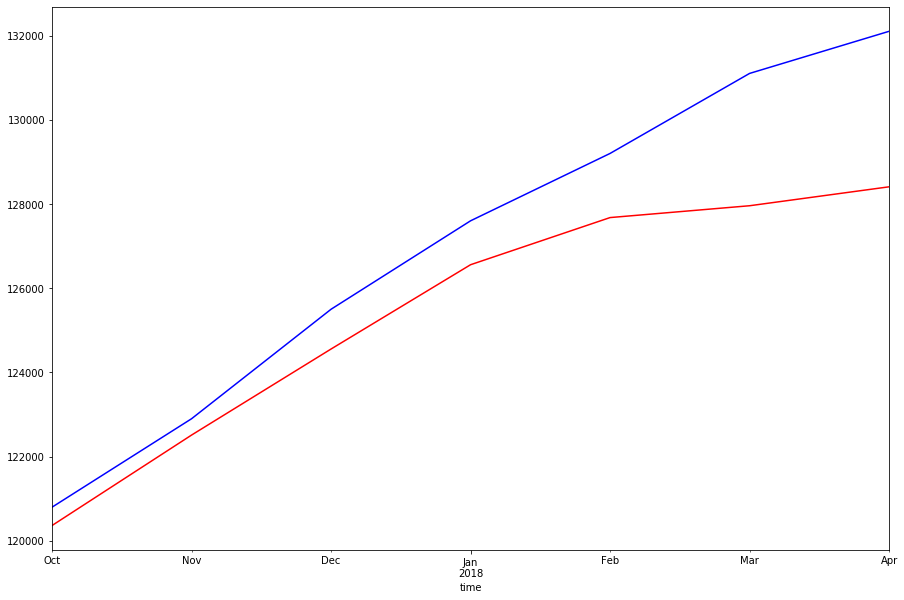

In [171]:
fig, ax = plt.subplots(figsize=(15,10))
test_dfs[5].plot(ax=ax, color='blue')
test_60505_preds.plot(ax=ax, color='red')

In [172]:
mse(test_dfs[5], test_60505_preds)

4021285.1536948183

In [179]:
sarima_test_predictions = []
sarima_models = []
for i in range(len(regions)):
    model = SARIMAX(train_dfs[i], order=sarimax_orders[i][0], seasonal_order=sarimax_orders[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
    test_preds = model.predict(start=test_dfs[i].index[0], end=test_dfs[i].index[-1], typ='levels')
    sarima_test_predictions.append(test_preds)
    sarima_models.append(model)

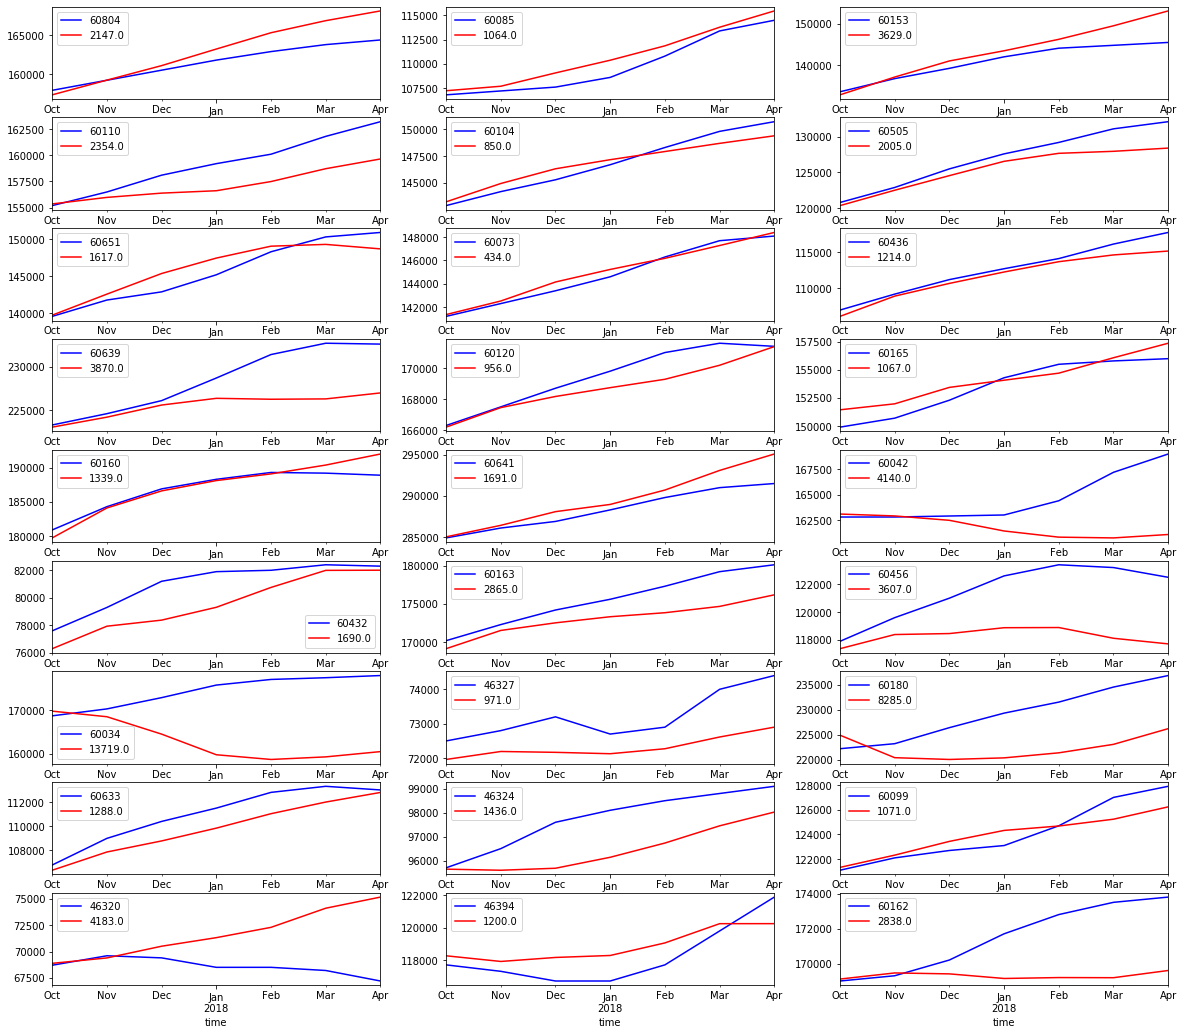

In [188]:
fig, ax = plt.subplots(9, 3, figsize=(20, 18))
i = 0
for row in range(9):
    for col in range(3):
        err = round(np.sqrt(mse(test_dfs[i], sarima_test_predictions[i])),0)
        test_dfs[i].plot(ax=ax[row][col], color='blue', label=regions[i])
        sarima_test_predictions[i].plot(ax=ax[row][col], color='red', label=err)
        ax[row][col].legend()
        i += 1

In [193]:
indices = []
for i in range(len(regions)):
    err = round(np.sqrt(mse(test_dfs[i], sarima_test_predictions[i])),0)
    if err < 2500:
        indices.append(i)

In [191]:
np.sort(rmse)

array([  434.,   850.,   956.,   971.,  1064.,  1067.,  1071.,  1200.,
        1214.,  1288.,  1339.,  1436.,  1617.,  1690.,  1691.,  2005.,
        2147.,  2354.,  2838.,  2865.,  3607.,  3629.,  3870.,  4140.,
        4183.,  8285., 13719.])

In [192]:
sarima_models

In [194]:
useful_models = []
for i in range(len(regions)):
    if i in indices:
        useful_models.append(sarima_models[i])

In [202]:
codes = []
params_list = []
for i in range(len(regions)):
    if i in indices:
        codes.append(regions[i])
        params_list.append(sarimax_orders[i])

In [201]:
codes

[60804,
 60085,
 60110,
 60104,
 60505,
 60651,
 60073,
 60436,
 60120,
 60165,
 60160,
 60641,
 60432,
 46327,
 60633,
 46324,
 60099,
 46394]

In [203]:
params_list

[((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 0), (1, 1, 0, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12))]

In [205]:
data = []
for i in indices:
    data.append(pd.concat([train_dfs[i], test_dfs[i]], axis=0))

In [208]:
sarima_60804 = SARIMAX(data[0], order=params_list[0][0], seasonal_order=params_list[0][1], enforce_invertibility=False, enforce_stationarity=False).fit()

In [209]:
sarima_60804.aic

634.6339600801531

In [219]:
regions[0]

60804

In [220]:
sarima_2 = SARIMAX(train_dfs[0], order=params_list[0][0], seasonal_order=params_list[0][1], enforce_invertibility=False, enforce_stationarity=False).fit()

In [221]:
sarima_2.aic

524.3379243343746

In [223]:
 current_aics = {}
 for i in range(len(regions)):
     model = SARIMAX(train_dfs[i], order=sarimax_orders[i][0], seasonal_order=sarimax_orders[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
     current_aics[regions[i]] = model.aic

In [226]:
current_aics

{60804: 524.3379243343746,
 60085: 529.8033324999087,
 60153: 539.8559736037942,
 60110: 503.85750494351794,
 60104: 488.387993372707,
 60505: 503.71056570726256,
 60651: 538.9091032818726,
 60073: 475.5666788687004,
 60436: 506.5347693363852,
 60639: 526.5377664920384,
 60120: 474.83242282804486,
 60165: 528.739514552793,
 60160: 547.6992935282248,
 60641: 533.2363858535743,
 60042: 529.0095241513752,
 60432: 550.4485337049385,
 60163: 528.2436758191664,
 60456: 543.0388486419312,
 60034: 568.0314220836774,
 46327: 220.3713418776815,
 60180: 575.7279668851925,
 60633: 524.5786805018079,
 46324: 502.84107309834815,
 60099: 501.20621689319694,
 46320: 247.9756055851572,
 46394: 547.656745209641,
 60162: 511.7534282748142}

In [231]:
new_aics

{60804: 634.6339600801531,
 60085: 643.433731643367,
 60110: 620.9226738560972,
 60104: 611.5844822181872,
 60505: 629.2578769985745,
 60651: 677.4719462577516,
 60073: 611.2896906615845,
 60436: 628.3376058053598,
 60120: 599.7967687697428,
 60165: 645.2798371426451,
 60160: 675.7872099934972,
 60641: 651.2213581475089,
 60432: 666.4475265235266,
 46327: 329.4243086705841,
 60633: 642.2036803197362,
 46324: 607.0563464176331,
 60099: 618.9593002620137,
 46394: 662.9372010899837}

In [230]:
new_aics = {}
for i in range(len(data)):
    model = SARIMAX(data[i], order=params_list[i][0], seasonal_order=params_list[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
    new_aics[codes[i]] = model.aic

In [232]:
new_sarimax_orders = []
for i in range(len(codes)):
    results = {}
    import itertools
    p = q = d = range(0, 2)
    pdq = list(itertools.product(p, d , q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter for SARIMA...')
    #for i in pdq:
    #    for s in seasonal_pdq:
    #        print('SARIMAX: {} x {}'.format(i, s))
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod =SARIMAX(data[i],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                result = mod.fit()
                results[result.aic] = (param, param_seasonal)
                print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,result.aic))
            except: 
                print('hello')
                continue
    min_ = np.min([x for x in results.keys() if str(x) != 'nan'])
    new_sarimax_orders.append(results[min_])

, 1, 1)x(1, 0, 1, 12) - AIC:806.1530832469892
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:651.2213581475089
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:639.8542223172344
Examples of parameter for SARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1600.4221470169666
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1279.1038379052172
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1105.2572524342443
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:846.3471459137872
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1118.7450351871507
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1031.3877773558386
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:859.3541188858903
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1026.763632877527
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1532.5534644212512
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1323.3567778696402
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1053.6883195139692
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:809.7687149703352
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1277.267756798325
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1230.8267313808872
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:839.5119750549779
ARIMA(0,

In [233]:
new_sarimax_orders

[((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((0, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12)),
 ((0, 1, 1), (0, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 0, 12)),
 ((0, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (1, 1, 1, 12)),
 ((1, 1, 1), (0, 1, 1, 12))]

In [235]:
best_aics = {}
for i in range(len(codes)):
    model = SARIMAX(data[i], order=new_sarimax_orders[i][0], seasonal_order=new_sarimax_orders[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
    best_aics[codes[i]] = model.aic

In [236]:
new_aics

{60804: 634.6339600801531,
 60085: 643.433731643367,
 60110: 620.9226738560972,
 60104: 611.5844822181872,
 60505: 629.2578769985745,
 60651: 677.4719462577516,
 60073: 611.2896906615845,
 60436: 628.3376058053598,
 60120: 599.7967687697428,
 60165: 645.2798371426451,
 60160: 675.7872099934972,
 60641: 651.2213581475089,
 60432: 666.4475265235266,
 46327: 329.4243086705841,
 60633: 642.2036803197362,
 46324: 607.0563464176331,
 60099: 618.9593002620137,
 46394: 662.9372010899837}

In [237]:
best_aics

{60804: 622.6686281128613,
 60085: 626.190403156997,
 60110: 604.0586885747398,
 60104: 611.5844822181872,
 60505: 616.4025549502755,
 60651: 660.00922799499,
 60073: 584.5032085273772,
 60436: 602.6424465633678,
 60120: 597.9675865349504,
 60165: 645.2798371426451,
 60160: 662.9116214578389,
 60641: 634.6560232503581,
 60432: 646.0218158790136,
 46327: 329.4243086705841,
 60633: 626.6430999373886,
 46324: 582.792931177605,
 60099: 618.9593002620137,
 46394: 647.1094113800373}

In [241]:
sarima_60804 = SARIMAX(data[0], order=new_sarimax_orders[0][0], seasonal_order=new_sarimax_orders[0][1], enforce_invertibility=False, enforce_stationarity=False).fit()
sarima_60804.forecast(steps=12).values[-1]

174419.18721511104

In [244]:
forecasts = {}
for i in range(len(codes)):
    model = SARIMAX(data[i], order=new_sarimax_orders[i][0], seasonal_order=new_sarimax_orders[i][1], enforce_invertibility=False, enforce_stationarity=False).fit()
    forecasts[codes[i]] = model.forecast(steps=12).values


In [245]:
forecasts

{60804: array([165051.13185113, 165728.69207398, 166023.77052378, 166042.00842759,
        166389.73544175, 167058.17474632, 168309.37619654, 169551.22518635,
        170518.33042175, 171378.83732098, 172819.64974247, 174419.18721511]),
 60085: array([114501.75606273, 114811.50424645, 115350.49504194, 115501.70736701,
        115196.21521642, 115756.18033176, 116910.19915828, 117962.01145848,
        119217.31826013, 121306.95935743, 123582.26831911, 124892.7451706 ]),
 60110: array([164124.09739786, 165373.31297799, 166590.26914171, 167800.97715788,
        168848.53671583, 169227.79444007, 170370.34910772, 171660.99561645,
        172776.26495303, 173840.58553465, 175307.9093879 , 176451.91920676]),
 60104: array([151342.46471034, 151700.83124445, 152376.35915333, 153628.17634164,
        155103.63777847, 155586.49979101, 156646.08450566, 157297.74714126,
        157885.77088491, 158786.65384315, 160120.09432363, 161410.16458502]),
 60505: array([132589.4518405 , 132694.65008839, 132

In [251]:
forecast_roi_60804 = ((forecasts[60804][-1] - data[0][-1])/data[0][-1]) * 100

In [252]:
forecast_roi_60804

6.0943961162475935

In [253]:
roi_forecasts = {}
for i in range(len(codes)):
    roi = ((forecasts[codes[i]][-1] - data[i][-1])/data[i][-1]) * 100
    roi_forecasts[codes[i]] = roi

In [296]:
roi_forecasts

{60804: 6.0943961162475935,
 60085: 9.07663333676852,
 60110: 8.120048533554963,
 60104: 7.106943984754474,
 60505: 10.672887891241539,
 60651: 10.076937877945328,
 60073: 5.8189367786882515,
 60436: 10.63642380200968,
 60120: 5.676459072215287,
 60165: 8.691447469709553,
 60160: 7.396861614667547,
 60641: 4.111362460450135,
 60432: 9.40643158254303,
 46327: 17.769341082597396,
 60633: 9.442758905739574,
 46324: 6.068917448292791,
 60099: 8.07495938447227,
 46394: 8.498062126290016}

In [255]:
df[df['RegionName'] == 46327]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
8780,78097,46327,Hammond,IN,Chicago,Lake,8781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55700,56000,56900,57300,57400,57700,59100,60000,59400,58400,57800,57600,57500,57600,57900,58300,58600,59400,60000,60800,63300,66600,69000,70900,72100,73200,74300,74700,74500,74900,75200,74600,73200,72500,72800,73200,72700,72900,74000,74400


In [289]:
forecast_range = pd.date_range(start='2018-04-01', end='2019-03-01', freq='MS')

In [290]:
forecast_range

DatetimeIndex(['2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01'],
              dtype='datetime64[ns]', freq='MS')

In [291]:
forecast_df = pd.DataFrame(index=forecast_range, columns = codes)

In [292]:
for code in codes:
    i=0
    for idx in forecast_range:
        forecast_df[code].loc[idx] = forecasts[code][i]
        i+=1

In [293]:
forecast_df

,60804,60085,60110,60104,60505,60651,60073,60436,60120,60165,60160,60641,60432,46327,60633,46324,60099,46394
2018-04-01,165051,114502,164124,151342,132589,151006,147951,118446,171416,156116,188683,292265,82371.3,75144.9,113835,99645.8,127818,122384
2018-05-01,165729,114812,165373,151701,132695,151174,148034,119191,172173,156267,188582,293345,82929.7,75703,115425,100070,127299,123022
2018-06-01,166024,115350,166590,152376,132848,151666,148488,120126,173509,156765,189299,294069,83802,76271.2,116338,100176,127490,124718
2018-07-01,166042,115502,167801,153628,133574,152696,148926,121188,174671,157329,190674,295041,84784.1,78112,116869,100132,128496,126496
2018-08-01,166390,115196,168849,155104,134847,154719,149570,122398,175887,158215,192833,296495,85565.2,80734.4,117881,100203,129443,127253
2018-09-01,167058,115756,169228,155586,134796,155140,149771,122865,176148,159875,194021,296606,85561.1,82728.2,118088,100350,130064,127678
2018-10-01,168309,116910,170370,156646,136893,157378,150965,124594,177212,162003,197070,297833,86705.7,84357.5,119676,101052,131226,127731
2018-11-01,169551,117962,171661,157298,139504,158811,152076,126327,178243,163454,199186,298634,88193.8,85422.5,120928,102146,132349,127665
2018-12-01,170518,119217,172776,157886,141628,161119,153249,127649,179190,164753,200317,300051,89012,86251,121823,102988,133436,128030
2019-01-01,171379,121307,173841,158787,143265,163806,154841,128267,180307,166506,201408,301608,89419.1,87198.4,122740,103706,134970,129016


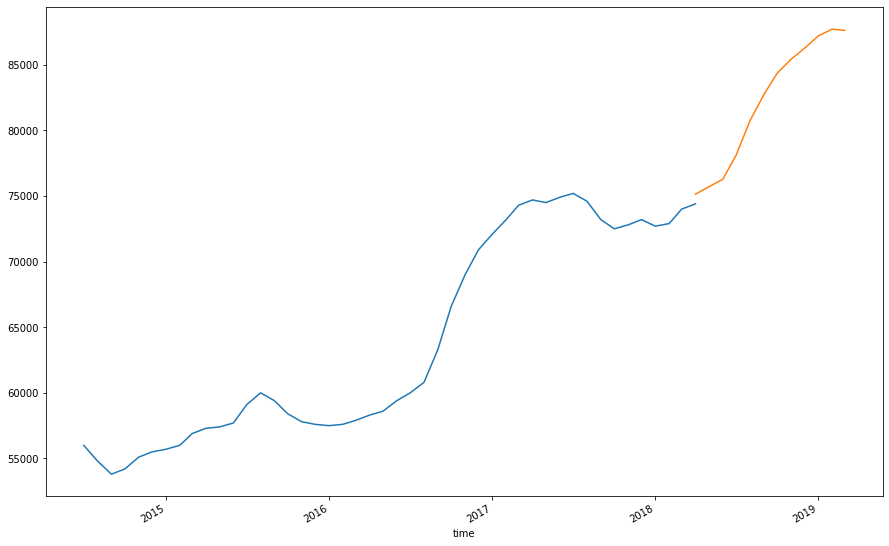

In [294]:
fig, ax = plt.subplots(figsize=(15, 10))
data[-5].plot(ax=ax)
forecast_df[46327].plot(ax=ax)

In [300]:
roi_sorted = {k:v for k,v in sorted(roi_forecasts.items(), key= lambda x: x[1], reverse=True)}

In [301]:
roi_sorted

{46327: 17.769341082597396,
 60505: 10.672887891241539,
 60436: 10.63642380200968,
 60651: 10.076937877945328,
 60633: 9.442758905739574,
 60432: 9.40643158254303,
 60085: 9.07663333676852,
 60165: 8.691447469709553,
 46394: 8.498062126290016,
 60110: 8.120048533554963,
 60099: 8.07495938447227,
 60160: 7.396861614667547,
 60104: 7.106943984754474,
 60804: 6.0943961162475935,
 46324: 6.068917448292791,
 60073: 5.8189367786882515,
 60120: 5.676459072215287,
 60641: 4.111362460450135}

In [303]:
recs = list(roi_sorted.keys())[:5]

In [304]:
recs

[46327, 60505, 60436, 60651, 60633]

In [306]:
recs_df = forecast_df[recs]

In [307]:
recs_df

,46327,60505,60436,60651,60633
2018-04-01,75144.9,132589,118446,151006,113835
2018-05-01,75703,132695,119191,151174,115425
2018-06-01,76271.2,132848,120126,151666,116338
2018-07-01,78112,133574,121188,152696,116869
2018-08-01,80734.4,134847,122398,154719,117881
2018-09-01,82728.2,134796,122865,155140,118088
2018-10-01,84357.5,136893,124594,157378,119676
2018-11-01,85422.5,139504,126327,158811,120928
2018-12-01,86251,141628,127649,161119,121823
2019-01-01,87198.4,143265,128267,163806,122740


In [308]:
past_df = df[df['RegionName'].isin(recs)]

In [332]:
past_df.fillna(0, inplace=True)

In [333]:
past_df_melted = mcf.melt_data(past_df)

In [334]:
past_date_range = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')

In [335]:
len(past_date_range)

265

In [336]:
len(past_df_melted[past_df_melted['RegionName'] == 46327])

265

In [337]:
new_df = pd.DataFrame(index = past_date_range)
# new_df['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
# new_df.set_index('time', inplace=True)
for rec in recs:
    new_df[rec] = past_df_melted[past_df_melted['RegionName'] == rec].value.values
    

In [338]:
new_df

,46327,60505,60436,60651,60633
1996-04-01,0.0,79300.0,78200.0,74700.0,77900.0
1996-05-01,0.0,80000.0,78300.0,75100.0,78200.0
1996-06-01,0.0,80200.0,78400.0,75400.0,78300.0
1996-07-01,0.0,80100.0,78500.0,75600.0,78500.0
1996-08-01,0.0,79700.0,78600.0,75600.0,78500.0
...,...,...,...,...,...
2017-12-01,73200.0,125500.0,111200.0,142900.0,110400.0
2018-01-01,72700.0,127600.0,112700.0,145200.0,111500.0
2018-02-01,72900.0,129200.0,114100.0,148300.0,112800.0
2018-03-01,74000.0,131100.0,116100.0,150300.0,113300.0


In [343]:
df2 = new_df['2015-01-01':]

In [ ]:
colors = ['#006d77']

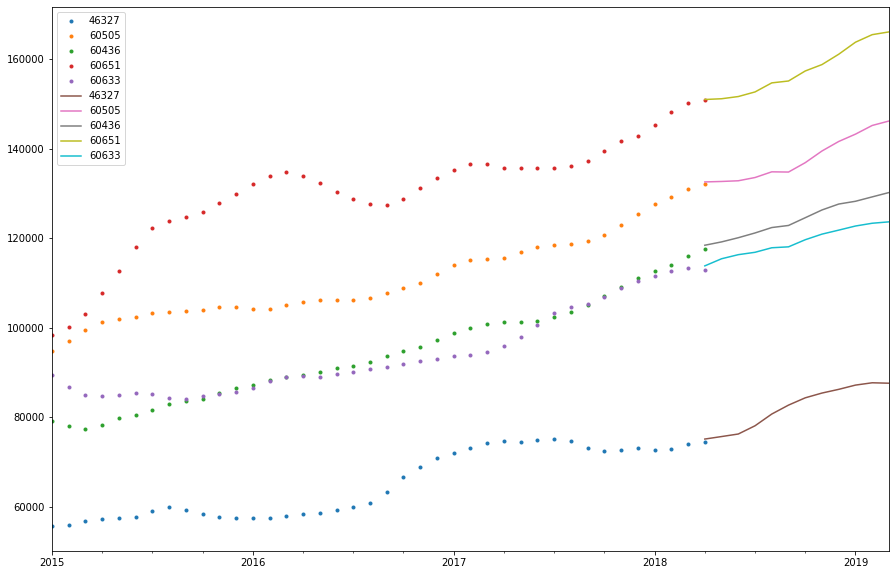

In [345]:
fig, ax = plt.subplots(figsize=(15, 10))
df2.plot(style='.', subplots=False, ax=ax)
recs_df.plot(subplots=False, ax=ax)

In [356]:
plotting_index = pd.date_range(start='2015-01-01', end='2019-03-01', freq='MS')

In [373]:
pallete = ['#03045e','#d90429','#774936','#7400b8','#007f5f']

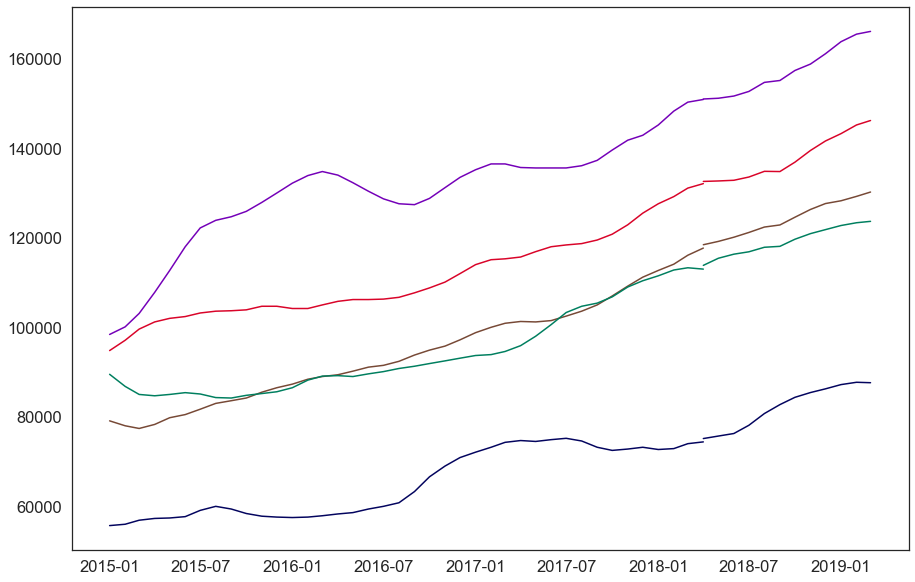

In [384]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})
for i in range(len(recs)):
    sns.lineplot(x=df2[recs[i]].index, y=df2[recs[i]].values, color=pallete[i], markers='-')
    sns.lineplot(x=recs_df[recs[i]].index, y=recs_df[recs[i]].values.astype(float), color=pallete[i])

In [351]:
recs_df

,46327,60505,60436,60651,60633
2018-04-01,75144.9,132589,118446,151006,113835
2018-05-01,75703,132695,119191,151174,115425
2018-06-01,76271.2,132848,120126,151666,116338
2018-07-01,78112,133574,121188,152696,116869
2018-08-01,80734.4,134847,122398,154719,117881
2018-09-01,82728.2,134796,122865,155140,118088
2018-10-01,84357.5,136893,124594,157378,119676
2018-11-01,85422.5,139504,126327,158811,120928
2018-12-01,86251,141628,127649,161119,121823
2019-01-01,87198.4,143265,128267,163806,122740


In [353]:
df2

,46327,60505,60436,60651,60633
2015-01-01,55700.0,94800.0,79100.0,98400.0,89500.0
2015-02-01,56000.0,97100.0,78000.0,100100.0,86800.0
2015-03-01,56900.0,99600.0,77400.0,103100.0,85000.0
2015-04-01,57300.0,101200.0,78300.0,107800.0,84700.0
2015-05-01,57400.0,102000.0,79800.0,112700.0,85000.0
2015-06-01,57700.0,102400.0,80500.0,118000.0,85400.0
2015-07-01,59100.0,103200.0,81700.0,122200.0,85100.0
2015-08-01,60000.0,103600.0,83000.0,123900.0,84300.0
2015-09-01,59400.0,103700.0,83600.0,124700.0,84200.0
2015-10-01,58400.0,103900.0,84200.0,125900.0,84800.0
